In [15]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from evaluate import compute_sim, evaluate

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

# infer_dir = 'D:'
infer_dir = '/Users/macbook/Downloads'

if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'

train_embs = pickle_load(f"{infer_dir}/train_embs.pkl")
test_embs = pickle_load(f"{infer_dir}/test_embs.pkl")
val_embs = pickle_load(f"{infer_dir}/val_embs.pkl")
train_df = pd.read_csv('data/train_kfold.csv')

train_embs = l2norm(train_embs)
test_embs = l2norm(test_embs)
val_embs = l2norm(val_embs)
len(train_embs) + len(val_embs)

51033

In [16]:
val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

In [17]:
from evaluate import compute_sim, evaluate, map_per_image

score, val_sim_df = evaluate(train_df, train_embs, val_embs)
val_sim_df["gt"] = val_sim_df.image.map(val_map)
val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
val_sim_df = val_sim_df.sort_values("map")
score

100%|██████████| 5710/5710 [00:06<00:00, 942.17it/s]


0.3923934617629889

In [18]:
from evaluate import dict2list
train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(val_embs)
class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))

cosines = np.matmul(test_v, train_v.T)

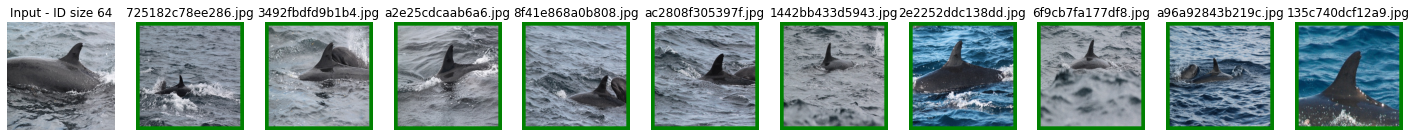

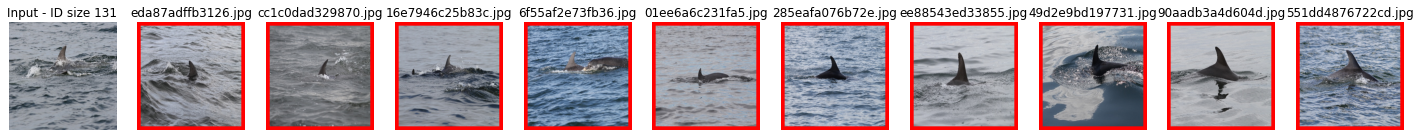

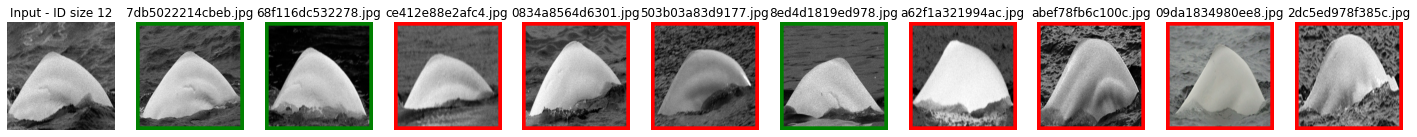

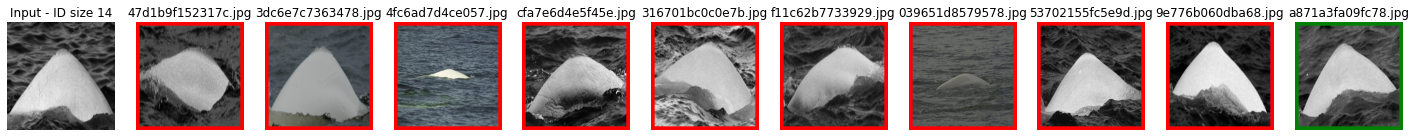

In [19]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

c = 0
for i, scores in enumerate(cosines):
    if np.random.rand() < 0.5:
        sort_idx = np.argsort(scores)[::-1]
        topk = [train_k[j] for j in sort_idx[:10]]
        topk_id = [train_map[x] for x in topk]
        qid = test_k[i]
        gt = train_map[qid]
        c+=1
        imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
        for k, l in zip(topk, topk_id):
            im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
            im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
            imgs.append(im)
        # Show image
        fig = plt.figure(figsize=(25, 4))
        columns = 11
        rows = 1
        for i2 in range(0, columns*rows):
            fig.add_subplot(rows, columns, i2+1)
            plt.title(f'Input - ID size {class_count[gt]}' if i2 == 0 else topk[i2 - 1])
            plt.imshow(imgs[i2])
            plt.axis('off')
        
        plt.show()
        
    if c == 4:
        break
    

In [20]:
# val_sim_df

sim_df = compute_sim(train_df, {**train_embs, **val_embs}, test_embs, thr=0.65)
sim_df[["image", "predictions"]].to_csv("submission.csv", index=False)
sim_df.head()

100%|██████████| 27956/27956 [00:31<00:00, 883.77it/s]


,image,predictions
0,a6e6e430843131.jpg,38e78862a8b0 new_individual 65115a5e60a4 90cfd...
1,552cd9c21fa9fc.jpg,5da95809a5a3 new_individual b3cb50b4eeb5 f8816...
2,000110707af0ba.jpg,fbe2b15b5481 new_individual 0a8709a3df9e 4eff5...
3,64d2c7622d6af7.jpg,new_individual 8d05a3dc25c6 cde58e997311 c260a...
4,b77331f7f25321.jpg,new_individual 51c6805b0d99 ec9131df4d9b 4f831...


In [21]:
def random_show(sim_df, is_val=False):
    sim_df = sim_df.copy()
    if is_val:
        sim_df = sim_df[sim_df["map"] < 0.5]
        sample = sim_df.iloc[np.random.choice(sim_df.index)]
        img1 = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{sample.image}')[:, :, ::-1]
        print("GT", sample["gt"], sample["map"])
    else:
        sample = sim_df.iloc[np.random.choice(sim_df.index)]
        img1 = cv2.imread(f'D:/whale_data/test_images-384-384/test_images-384-384/{sample.image}')[:, :, ::-1]
        
    imgs = [img1]

    ids = sample.predictions.split(" ")
    for i in range(5):
        if ids[i] != 'new_individual':
            path = train_df[train_df.individual_id == ids[i]].values[0][0]
            img = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{path}')[:, :, ::-1]
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i == 0:
            plt.title('Input')
        else:
            plt.title(ids[i-1])
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(val_sim_df, is_val=True)
# random_show(sim_df, is_val=False)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
raise
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=100,metric='cosine')

train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

RuntimeError: No active exception to reraise

In [ ]:
distances, idxs = knn.kneighbors(test_v, 100, return_distance=True)

In [ ]:
test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d]) 
    

test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

In [ ]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']


In [ ]:
predictions = {}
for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence > 0.5:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

In [ ]:
# sim_df = sim_df.sort_values('image')
# sim_df.to_csv('submission.csv', index=False)

# s655_df = pd.read_csv('submission_655.csv')
# s655_df= s655_df.sort_values('image')
# s655_df.to_csv('submission_655.csv', index=False)

In [ ]:
sub_df = pd.read_csv("submission.csv")
sub_df["top1"] = sub_df["predictions"].apply(lambda x: x.split(" ")[0])
sub_df2 = pd.read_csv("submission_655.csv")
sub_df2["top1"] = sub_df2["predictions"].apply(lambda x: x.split(" ")[0])

sub_df = sub_df.sort_values('image')
sub_df2 = sub_df2.sort_values('image')

0.0005723279439118615